In [1]:
import pandas as pd
import warnings
import seaborn as sns
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec
import itertools
from sklearn.naive_bayes import GaussianNB
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

In [2]:

# Ensure NLTK data is downloaded
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')  # Required for lemmatization

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:

# Load the datasets
news_df = pd.read_csv('./data/us_equities_news_dataset.csv')
stock_df = pd.read_csv('./data/NVDA.csv')

In [4]:
# Sample keywords related to NVIDIA and associated companies
nvidia_keywords = [
    'NVDA', 'NVIDIA','GPU', 'GRAPHICS']

'''

More keywords can be added to the list to improve the filtering process. But adding all those increases the document number significantly making processing slower and creating memory issues that are unsolvable by my mere laptop. 

nvidia_keywords = [
    'NVDA', 'NVIDIA', 'NIO', 'UBER', 'AMZN', 'AMAZON', 'TESLA', 'AI', 'GPU', 'GRAPHICS',
    'CHIP', 'SEMICONDUCTOR', 'AUTONOMOUS', 'DRIVING', 'DEEP LEARNING', 'MACHINE LEARNING'
]

'''
# Suppress all warnings
warnings.filterwarnings('ignore')

# Compile a regex pattern from the keywords list
nvidia_pattern = '|'.join(nvidia_keywords)  # Combines the keywords into a regex pattern

# Filter articles where the content or ticker column contains any of the keywords
nvidia_related_articles = news_df[
    news_df['content'].str.contains(nvidia_pattern, case=False, na=False) |
    news_df['ticker'].str.contains(nvidia_pattern, case=False, na=False)
]

# Display the count of NVIDIA-related articles
print(f"\nTotal NVIDIA-related articles found: {nvidia_related_articles.shape[0]}")

# Convert the date columns to datetime format for matching
nvidia_related_articles['Date'] = pd.to_datetime(nvidia_related_articles['release_date'])
stock_df['Date'] = pd.to_datetime(stock_df['Date'])

# Merge filtered news data with stock prices based on publication date
merged_df = pd.merge(nvidia_related_articles, stock_df, on='Date', how='inner')

# Filter to keep only articles that have matching stock data
nvidia_df = merged_df[['content', 'Open', 'Close', 'Date']]

# Label the target variable based on the opening and closing prices
nvidia_df['target'] = np.where(nvidia_df['Open'] > nvidia_df['Close'], 0, 1)

# Display the first few rows to verify the merging and labeling
print("\nFiltered and Labeled Data:")
print(nvidia_df.head())




Total NVIDIA-related articles found: 4982

Filtered and Labeled Data:
                                             content     Open    Close  \
0  ECB Effects\nThe move in the euro was huge  fa...  3.77750  3.73150   
1  6 Stocks To Watch  March 6 Trading Session\nSt...  3.90400  3.80125   
2  Investing com   A rout in Apple and Facebook  ...  4.04475  3.61750   
3  With 4 500 companies bringing their innovation...  6.19300  6.22325   
4  With 4 500 companies bringing their innovation...  6.18325  6.10800   

        Date  target  
0 2019-03-07       0  
1 2019-03-06       0  
2 2018-11-19       0  
3 2020-01-16       1  
4 2020-01-10       0  


In [5]:
# Check for duplicate documents based on the 'content' column
duplicate_docs = nvidia_df[nvidia_df['content'].duplicated(keep=False)]

# Display the duplicate documents (if any)
print(f"Number of duplicate documents found: {duplicate_docs.shape[0]}")
if not duplicate_docs.empty:
    print("Duplicate Documents:")
    print(duplicate_docs[['content']])

# Remove duplicate documents, keeping the first occurrence
nvidia_df = nvidia_df.drop_duplicates(subset='content', keep='first').reset_index(drop=True)

# Display the updated DataFrame
print(f"Number of documents after removing duplicates: {nvidia_df.shape[0]}")


Number of duplicate documents found: 19
Duplicate Documents:
                                                content
1347  EquitiesAsian markets rose on Friday  followin...
1348  EquitiesAsian markets rose on Friday  followin...
1349  EquitiesAsian markets rose on Friday  followin...
1350  EquitiesAsian markets rose on Friday  followin...
1351  EquitiesAsian markets rose on Friday  followin...
1352  EquitiesAsian markets rose on Friday  followin...
1353  EquitiesAsian markets rose on Friday  followin...
1354  EquitiesAsian markets rose on Friday  followin...
1355  EquitiesAsian markets rose on Friday  followin...
1356  EquitiesAsian markets rose on Friday  followin...
1357  EquitiesAsian markets rose on Friday  followin...
1358  EquitiesAsian markets rose on Friday  followin...
1359  EquitiesAsian markets rose on Friday  followin...
1614  Advanced Micro Devices   NASDAQ AMD   reported...
1615  Advanced Micro Devices   NASDAQ AMD   reported...
1617  Semiconductor stocks have been mixed 

In [6]:

# Basic descriptive statistics for the news dataset
num_articles = nvidia_df.shape[0]
average_words_per_article = nvidia_df['content'].apply(lambda x: len(str(x).split())).mean()
print(f'The number of articles before filtering is: {news_df.shape[0]}')
print(f"The number of articles after filtering is: {num_articles}")
print(f"The average amount of words per article is: {average_words_per_article}")

The number of articles before filtering is: 221513
The number of articles after filtering is: 4410
The average amount of words per article is: 765.684126984127


In [7]:
# Tokenize each document to create a list of words
all_words_before = [word for content in nvidia_df['content'] for word in word_tokenize(content.lower())]

# Calculate the total number of words
total_words = len(all_words_before)

# Calculate the number of unique words
unique_words = len(set(all_words_before))

# Calculate lexical richness as the ratio of unique words to the total number of words
lexical_richness = unique_words / total_words

# Print the results
print(f"Total number of words: {total_words}")
print(f"Number of unique words: {unique_words}")
print(f"Lexical richness: {lexical_richness:.4f}")


Total number of words: 3376835
Number of unique words: 66332
Lexical richness: 0.0196


In [8]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Remove stopwords and punctuation for better NLP insights
stop_words = set(stopwords.words('english'))

# Tokenize content, remove stopwords, and apply lemmatization
def lemmatize_words(words):
    return [lemmatizer.lemmatize(word) for word in words if word.isalpha() and word not in stop_words]

nvidia_df['processed_text'] = nvidia_df['content'].apply(lambda x: word_tokenize(str(x).lower()))
nvidia_df['filtered_text'] = nvidia_df['processed_text'].apply(lemmatize_words)

# Join the filtered words back into strings for TF-IDF
nvidia_df['filtered_text_str'] = nvidia_df['filtered_text'].apply(lambda x: ' '.join(x))

# Display the first few rows of the preprocessed data
print(nvidia_df.head())


                                             content     Open    Close  \
0  ECB Effects\nThe move in the euro was huge  fa...  3.77750  3.73150   
1  6 Stocks To Watch  March 6 Trading Session\nSt...  3.90400  3.80125   
2  Investing com   A rout in Apple and Facebook  ...  4.04475  3.61750   
3  With 4 500 companies bringing their innovation...  6.19300  6.22325   
4  With 4 500 companies bringing their innovation...  6.18325  6.10800   

        Date  target                                     processed_text  \
0 2019-03-07       0  [ecb, effects, the, move, in, the, euro, was, ...   
1 2019-03-06       0  [6, stocks, to, watch, march, 6, trading, sess...   
2 2018-11-19       0  [investing, com, a, rout, in, apple, and, face...   
3 2020-01-16       1  [with, 4, 500, companies, bringing, their, inn...   
4 2020-01-10       0  [with, 4, 500, companies, bringing, their, inn...   

                                       filtered_text  \
0  [ecb, effect, move, euro, huge, falling, pip,

In [9]:
# Frequency analysis of the most common words
all_words = [word for content in nvidia_df['filtered_text'] for word in content]
word_freq = Counter(all_words)
most_common_words = word_freq.most_common(100)

# Display the most common words in the news dataset
print("\nTop 100 most common words in the news articles (after stop word removal):")
print(most_common_words)


Top 100 most common words in the news articles (after stop word removal):
[('year', 23382), ('company', 21079), ('stock', 18228), ('nasdaq', 15348), ('zacks', 14329), ('market', 14092), ('earnings', 12720), ('quarter', 12085), ('growth', 11371), ('share', 10494), ('revenue', 9045), ('u', 8565), ('also', 8376), ('billion', 8148), ('nvidia', 8074), ('nyse', 7789), ('new', 7361), ('million', 7133), ('estimate', 6938), ('technology', 6380), ('investor', 6254), ('inc', 6250), ('last', 6222), ('price', 6127), ('rank', 6007), ('expected', 5509), ('time', 5486), ('per', 5405), ('one', 5397), ('investment', 5242), ('industry', 5174), ('high', 5113), ('p', 5050), ('sale', 5040), ('report', 5033), ('day', 4956), ('said', 4917), ('buy', 4867), ('strong', 4796), ('business', 4785), ('like', 4778), ('data', 4747), ('week', 4628), ('rate', 4596), ('product', 4455), ('see', 4453), ('analyst', 4365), ('consensus', 4261), ('trade', 4258), ('month', 4231), ('apple', 4146), ('top', 4088), ('well', 4051),

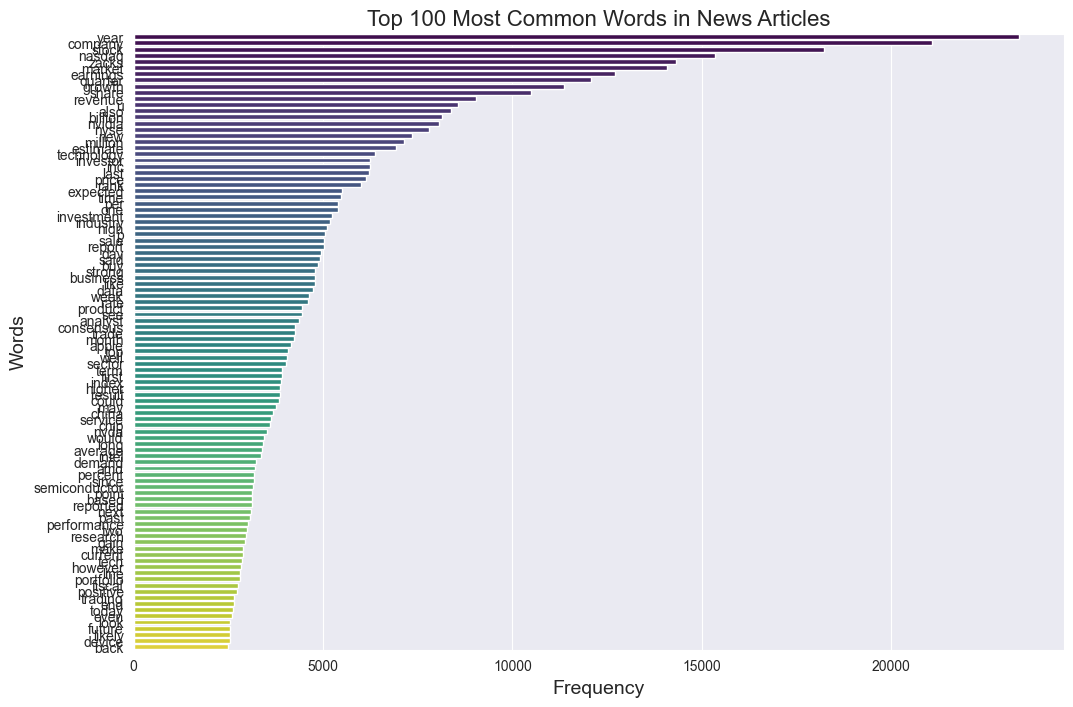

In [10]:

# Split the words and their frequencies for plotting
words, frequencies = zip(*most_common_words)

# Suppress all warnings
warnings.filterwarnings('ignore')

# Plot the top 100 most common words as a bar chart
plt.figure(figsize=(12,8))
sns.barplot(x=list(frequencies), y=list(words), palette="viridis")
plt.title('Top 100 Most Common Words in News Articles', fontsize=16)
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Words', fontsize=14)
plt.show()

In [11]:
# Flatten the list of filtered words into a single list
all_words = [word for content in nvidia_df['filtered_text'] for word in content]

# Calculate the total number of words
total_words = len(all_words)

# Calculate the number of unique words
unique_words = len(set(all_words))

# Calculate lexical richness as the ratio of unique words to the total number of words
lexical_richness = unique_words / total_words

# Print the results
print(f"After Preprocessing")
print(f"Total number of words: {total_words}")
print(f"Number of unique words: {unique_words}")
print(f"Lexical richness: {lexical_richness:.4f}")

print(f"The average amount of words per article is: {average_words_per_article}")

After Preprocessing
Total number of words: 1906535
Number of unique words: 38914
Lexical richness: 0.0204
The average amount of words per article is: 765.684126984127


In [12]:
# Count the occurrence of each label (target variable)
label_counts = nvidia_df['target'].value_counts()

# Print the counts of each label
print("Label Distribution:")
print(label_counts)

Label Distribution:
target
1    2363
0    2047
Name: count, dtype: int64


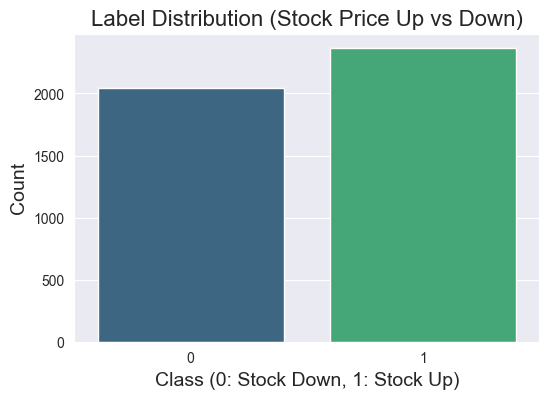

In [13]:

# Plot the label distribution using a bar chart
plt.figure(figsize=(6,4))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
plt.title('Label Distribution (Stock Price Up vs Down)', fontsize=16)
plt.xlabel('Class (0: Stock Down, 1: Stock Up)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

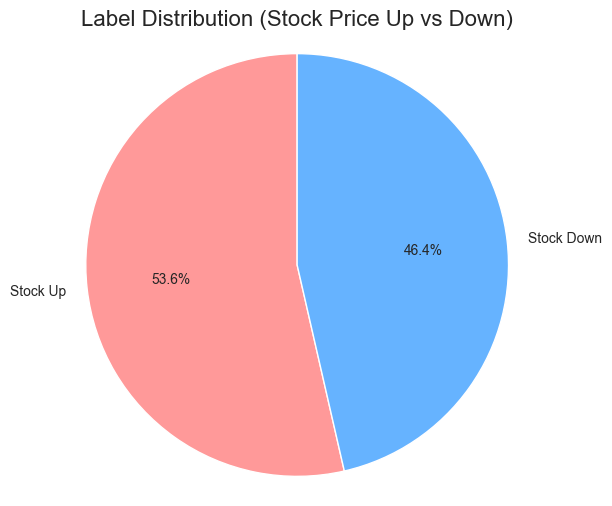

In [14]:

#Visualize the label distribution using a pie chart
plt.figure(figsize=(6,6))
plt.pie(label_counts, labels=['Stock Up', 'Stock Down'], autopct='%1.1f%%', startangle=90, colors=["#ff9999","#66b3ff"])
plt.title('Label Distribution (Stock Price Up vs Down)', fontsize=16)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


In [15]:
# Define custom stop words that don't add value
custom_stop_words = ['stock', 'company', 'market', 'year']  

# Merge the custom stop words with NLTK's default English stop words
stop_words = set(stopwords.words('english')).union(custom_stop_words)

# TF-IDF Representation of Documents using the processed and filtered text
vectorizer = TfidfVectorizer(
    stop_words='english', 
    max_features=500,  # Reduce max features for computational efficiency
    ngram_range=(1, 3)  # Use unigrams, bigrams, and trigrams
)
tfidf_matrix = vectorizer.fit_transform(nvidia_df['filtered_text_str'])

In [16]:
# Train a linear classifier (e.g., Logistic Regression) on the TF-IDF matrix
clf = LogisticRegression(max_iter=1000)
clf.fit(tfidf_matrix, nvidia_df['target'])

LogisticRegression(max_iter=1000)

In [17]:
def print_top_features(vectorizer, coef):
    """Prints features with the highest coefficient values for binary classification."""
    feature_names = vectorizer.get_feature_names_out()
    
    # Top 20 features with the most negative coefficients (indicative of Class 0)
    top_features_class_0 = np.argsort(coef)[:20]
    print("\nTop 20 Words Indicative of Class 0 (Stock Price Down):")
    print(" ".join(feature_names[j] for j in top_features_class_0))
    
    # Top 20 features with the most positive coefficients (indicative of Class 1)
    top_features_class_1 = np.argsort(coef)[-20:]
    print("\nTop 20 Words Indicative of Class 1 (Stock Price Up):")
    print(" ".join(feature_names[j] for j in top_features_class_1))
    
    return top_features_class_0, top_features_class_1

# Extract the coefficients from the classifier
coef = clf.coef_[0]

# Print the most informative features and get the indices for visualization
top_features_class_0, top_features_class_1 = print_top_features(vectorizer, coef)


Top 20 Words Indicative of Class 0 (Stock Price Down):
net fell level business china power recent run trade corporate today make use tuesday tesla friday decline increased bitcoin improved

Top 20 Words Indicative of Class 1 (Stock Price Up):
target income near taking amazon monday compared cloud esp video basis dollar government autonomous mark maker chip global gain rose


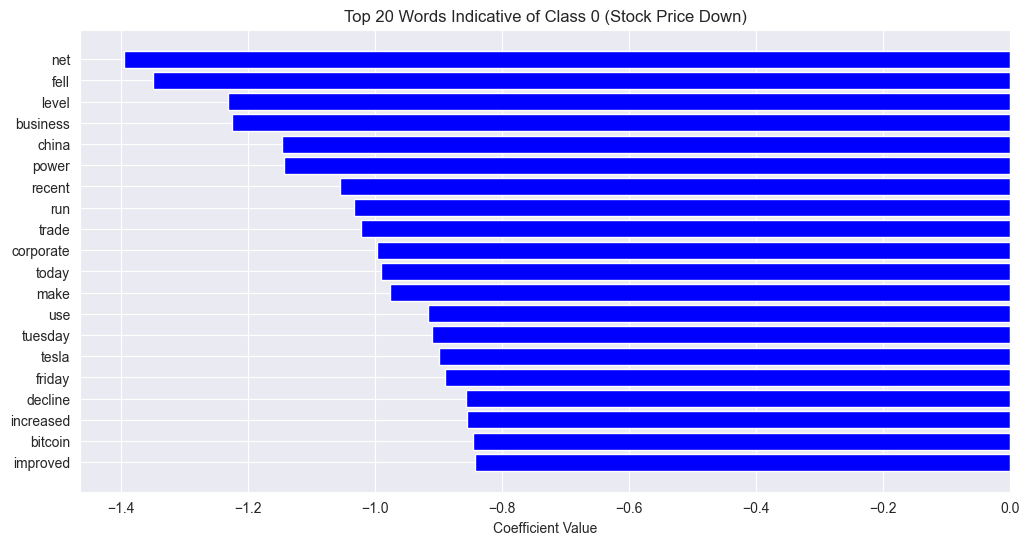

In [18]:

# Visualize the top features for Class 0 (Stock Price Down)
plt.figure(figsize=(12, 6))
plt.barh([vectorizer.get_feature_names_out()[i] for i in top_features_class_0], coef[top_features_class_0], color='blue')
plt.title('Top 20 Words Indicative of Class 0 (Stock Price Down)')
plt.xlabel('Coefficient Value')
plt.gca().invert_yaxis()
plt.show()



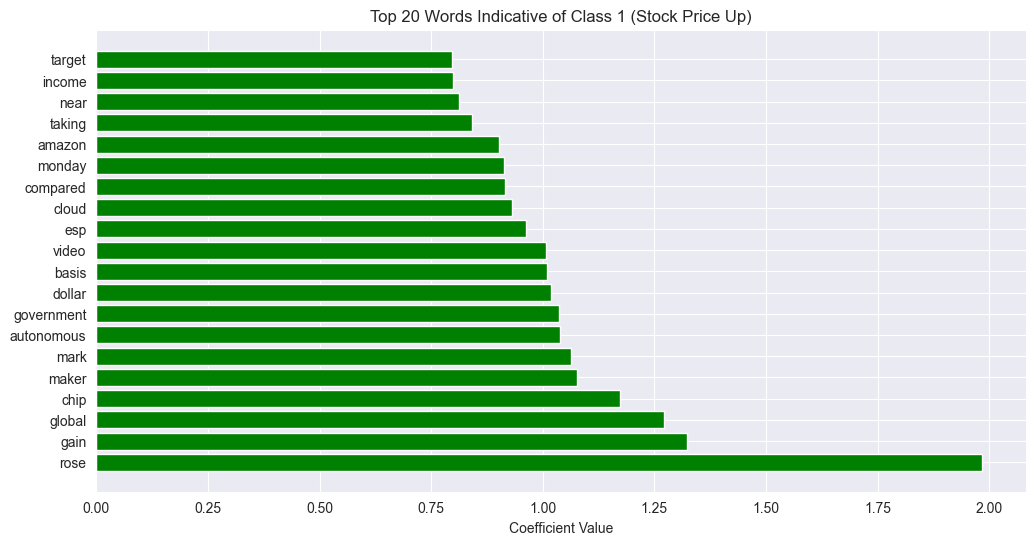

In [19]:
# Visualize the top features for Class 1 (Stock Price Up)
plt.figure(figsize=(12, 6))
plt.barh([vectorizer.get_feature_names_out()[i] for i in top_features_class_1], coef[top_features_class_1], color='green')
plt.title('Top 20 Words Indicative of Class 1 (Stock Price Up)')
plt.xlabel('Coefficient Value')
plt.gca().invert_yaxis()
plt.show()

In [20]:
# Check the shape of the tfidf_matrix
print(f"Shape of tfidf_matrix: {tfidf_matrix.shape}")

# Number of documents (rows) and terms (columns)
num_documents, num_features = tfidf_matrix.shape
print(f"Number of documents: {num_documents}")
print(f"Number of features (terms): {num_features}")

# Check the number of non-zero elements
non_zero_elements = tfidf_matrix.nnz
print(f"Number of non-zero elements: {non_zero_elements}")

# Calculate the total number of elements
total_elements = num_documents * num_features
print(f"Total number of elements: {total_elements}")

# Calculate the sparsity of the matrix
sparsity = (1 - (non_zero_elements / total_elements)) * 100
print(f"Sparsity of the tfidf_matrix: {sparsity:.2f}%")

Shape of tfidf_matrix: (4410, 500)
Number of documents: 4410
Number of features (terms): 500
Number of non-zero elements: 459309
Total number of elements: 2205000
Sparsity of the tfidf_matrix: 79.17%


In [21]:
# Compute cosine similarity matrix, which measures the similarity between documents

similarity_matrix = cosine_similarity(tfidf_matrix)

# Convert similarity matrix to a DataFrame for easier handling
similarity_df = pd.DataFrame(similarity_matrix)

In [22]:
# Check the shape of the similarity_matrix
print(f"Shape of similarity_matrix: {similarity_matrix.shape}")

# Number of documents (rows and columns since it's square)
num_documents = similarity_matrix.shape[0]
print(f"Number of documents: {num_documents}")

# Check the number of non-zero elements in the similarity matrix
non_zero_elements = np.count_nonzero(similarity_matrix)
print(f"Number of non-zero elements: {non_zero_elements}")

# Calculate the total number of elements in the similarity matrix
total_elements = num_documents * num_documents
print(f"Total number of elements: {total_elements}")

# Calculate the sparsity of the similarity matrix
sparsity = (1 - (non_zero_elements / total_elements)) * 100
print(f"Sparsity of the similarity_matrix: {sparsity:.2f}%")

Shape of similarity_matrix: (4410, 4410)
Number of documents: 4410
Number of non-zero elements: 19395686
Total number of elements: 19448100
Sparsity of the similarity_matrix: 0.27%


In [23]:
# Find indices of the most and least similar documents (excluding self-similarity)
np.fill_diagonal(similarity_matrix, 0.0001)

In [24]:
# Find the maximum value in the similarity matrix
max_similarity = np.max(similarity_matrix)
print(f"Maximum similarity value (excluding self-similarity): {max_similarity}")

# Find the minimum value in the similarity matrix
min_similarity = np.min(similarity_matrix)
print(f"Minimum similarity value (excluding self-similarity): {min_similarity}")

Maximum similarity value (excluding self-similarity): 1.0000000000000004
Minimum similarity value (excluding self-similarity): 0.0


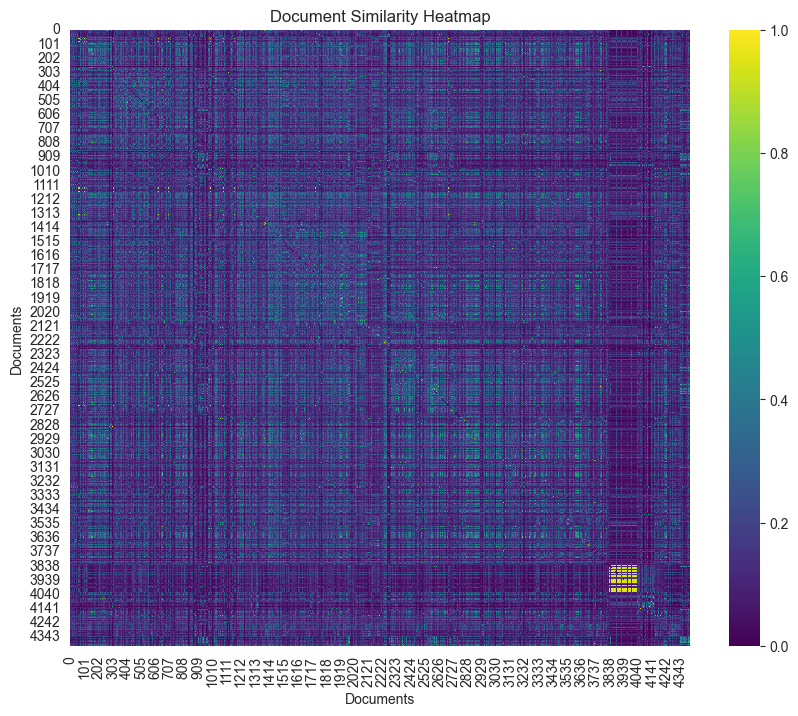

In [25]:

# Create a heatmap of the similarity matrix
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, cmap='viridis', cbar=True)
plt.title('Document Similarity Heatmap')
plt.xlabel('Documents')
plt.ylabel('Documents')
plt.show()

https://datascience.stackexchange.com/questions/101862/cosine-similarity-between-sentence-embeddings-is-always-positive



In [26]:
most_similar_indices = np.unravel_index(np.argmax(similarity_matrix, axis=None), similarity_matrix.shape)
least_similar_indices = np.unravel_index(np.argmin(similarity_matrix, axis=None), similarity_matrix.shape)

In [27]:
# Inspect the most similar documents 
similar_doc_1 = nvidia_df.iloc[most_similar_indices[0]]
similar_doc_2 = nvidia_df.iloc[most_similar_indices[1]]

print("\nMost Similar Documents:\n")
print("Document 1:")
print(similar_doc_1['content'])
print("\nDocument 2:")
print(similar_doc_2['content'])


Most Similar Documents:

Document 1:
Investing com   NVIDIA  NASDAQ NVDA  fell by 3 14  to trade at  160 26 by 09 30  13 30 GMT  on Wednesday on the NASDAQ exchange 
The volume of NVIDIA shares traded since the start of the session was 7 29M  NVIDIA has traded in a range of  160 26 to  160 26 on the day 
The stock has traded at  173 4500 at its highest and  160 2600 at its lowest during the past seven days 

Document 2:
Investing com   NVIDIA  NASDAQ NVDA  fell by 3 04  to trade at  151 30 by 09 36  13 36 GMT  on Wednesday on the NASDAQ exchange 
The volume of NVIDIA shares traded since the start of the session was 579 25K  NVIDIA has traded in a range of  151 11 to  152 82 on the day 
The stock has traded at  158 3100 at its highest and  149 2000 at its lowest during the past seven days 


In [28]:

# Inspect the least similar documents
dissimilar_doc_1 = nvidia_df.iloc[least_similar_indices[0]]
dissimilar_doc_2 = nvidia_df.iloc[least_similar_indices[1]]

print("\n\nMost Dissimilar Documents:\n")
print("Document 1:")
print(dissimilar_doc_1['content'])
print("\nDocument 2:")
print(dissimilar_doc_2['content'])





Most Dissimilar Documents:

Document 1:
6 Stocks To Watch  March 6 Trading Session
Stocks
Stocks went pretty much nowhere on March 5  with the S P 500 finishing the day down about 10 bps  I was modestly surprised that stocks didn t get a boost from the strong services PMI data which came in at 59 7 versus estimates of 57 2  It was one of the highest reading in some time 

Let us not forget that the services industry in the US far outweighs the manufacturing sector 

While it is nice to obsess about weak manufacturing PMI s because it sounds so dire and creates headlines of doom  let s just stop and call it a day 
Biotech  XBI 
BiotechI stocks plunged on the news that FDA Commish Dr  Scott Gottlieb is resigning  The only reason for the decline is that the market fears the unknown  and not knowing the next commissioner is the unknown  Sell first  ask questions later 
You can see from the chart below that the day was going rather well for Biotech  that is  before the news 

Netflix  NFL

In [29]:
# Prepare the text data for Word2Vec
sentences = nvidia_df['filtered_text'].tolist()

In [30]:
def document_embedding_tfidf(model, document, tfidf, feature_names, vector_size=100):
    """
    Compute a TF-IDF weighted document embedding by averaging the Word2Vec embeddings of words in the document.

    Parameters:
    - model: Trained Word2Vec model
    - document: List of tokenized words
    - tfidf: TfidfVectorizer object used for the document
    - feature_names: The list of features (terms) from the TF-IDF vectorizer
    - vector_size: Size of the word embeddings in the Word2Vec model

    Returns:
    - doc_embedding: The TF-IDF weighted document embedding as a numpy array
    """
    word_vectors = []
    weights = []

    # Extract the TF-IDF scores for the document
    tfidf_scores = tfidf.transform([" ".join(document)])
    tfidf_scores = tfidf_scores.toarray().flatten()

    feature_names = feature_names.tolist()  # Convert NumPy array to list

    for word in document:
        if word in model.wv.index_to_key and word in feature_names:
            # Get the word embedding
            word_vector = model.wv[word]
            word_index = feature_names.index(word)  # Get the index of the word in the TF-IDF feature list

            # Get the TF-IDF weight for this word
            tfidf_weight = tfidf_scores[word_index]

            # Collect the word vector and weight
            word_vectors.append(word_vector)
            weights.append(tfidf_weight)

    if len(word_vectors) == 0:
        # Return a zero vector if no words from the document are in the Word2Vec model
        return np.zeros(vector_size)

    # Convert lists to arrays
    word_vectors = np.array(word_vectors)
    weights = np.array(weights)

    # Compute the weighted average of word vectors
    doc_embedding = np.average(word_vectors, axis=0, weights=weights)

    return doc_embedding



In [31]:
# Define the grid of parameters to test
'''
vector_sizes = [100, 200, 300]
window_sizes = [3, 5, 7]
min_counts = [1, 5, 10]
sg_values = [0, 1]  # 0 for CBOW, 1 for Skip-gram
epochs = [10, 20]
'''

'\nvector_sizes = [100, 200, 300]\nwindow_sizes = [3, 5, 7]\nmin_counts = [1, 5, 10]\nsg_values = [0, 1]  # 0 for CBOW, 1 for Skip-gram\nepochs = [10, 20]\n'

### Accuracy as the best metric for evaluation

In [32]:
# Dictionary to store best performance for each model configuration and classifier
best_performance = {
    'Word2Vec_with_negative_sampling_with_TFIDF': {
        'LogisticRegression': {'best_f1_score': 0, 'best_accuracy': 0, 'best_params': None},
        'GaussianNB': {'best_f1_score': 0, 'best_accuracy': 0, 'best_params': None}
    },
    'Word2Vec_with_negative_sampling_without_TFIDF': {
        'LogisticRegression': {'best_f1_score': 0, 'best_accuracy': 0, 'best_params': None},
        'GaussianNB': {'best_f1_score': 0, 'best_accuracy': 0, 'best_params': None}
    },
    'Word2Vec_without_negative_sampling_with_TFIDF': {
        'LogisticRegression': {'best_f1_score': 0, 'best_accuracy': 0, 'best_params': None},
        'GaussianNB': {'best_f1_score': 0, 'best_accuracy': 0, 'best_params': None}
    },
    'Word2Vec_without_negative_sampling_without_TFIDF': {
        'LogisticRegression': {'best_f1_score': 0, 'best_accuracy': 0, 'best_params': None},
        'GaussianNB': {'best_f1_score': 0, 'best_accuracy': 0, 'best_params': None}
    }
}



# Function to update the best performance for a given configuration and classifier
def update_best_performance(model_type, classifier_type, f1, accuracy, params):
    if  accuracy > best_performance[model_type][classifier_type]['best_accuracy']:
        best_performance[model_type][classifier_type]['best_f1_score'] = f1
        best_performance[model_type][classifier_type]['best_accuracy'] = accuracy
        best_performance[model_type][classifier_type]['best_params'] = params



In [33]:
from sklearn.naive_bayes import GaussianNB

# Define the grid of parameters to test
vector_sizes = [100,200]
window_sizes = [3,5,7]
min_counts = [1,5,10]
sg_values = [0,1]  # 0 for CBOW, 1 for Skip-gram
epochs = [20]
negative_samples = [True,None]  # None means no negative sampling
use_tfidf = [True,None]  # For with/without TF-IDF

# Initialize TF-IDF vectorizer and compute feature names
tfidf_feature_names = vectorizer.get_feature_names_out()

# Iterate over all combinations of parameters including TF-IDF and negative sampling
for vector_size, window, min_count, sg, epoch, negative, use_tfidf_flag in itertools.product(vector_sizes, window_sizes, min_counts, sg_values, epochs, negative_samples, use_tfidf):
    
    # Model identifier for storing results
    model_type = f'Word2Vec_{"with" if negative else "without"}_negative_sampling_{"with_TFIDF" if use_tfidf_flag else "without_TFIDF"}'
    
    if sg==1:
        sg_name='Skip-Gram'
    else:
        sg_name='CBOW'
    
    # Initialize Word2Vec with or without negative sampling
    if negative is not None:
        word2vec_model = Word2Vec(sentences, vector_size=vector_size, window=window, min_count=min_count, workers=4, sg=sg, negative=negative)
    else:
        word2vec_model = Word2Vec(sentences, vector_size=vector_size, window=window, min_count=min_count, workers=4, sg=sg)
    
    # Train the model
    word2vec_model.train(sentences, total_examples=len(sentences), epochs=epoch)

    # Document embeddings, with or without TF-IDF
    if use_tfidf_flag:
        # Assuming TF-IDF embedding code here
        doc_embeddings = nvidia_df['filtered_text'].apply(
            lambda doc: document_embedding_tfidf(word2vec_model, doc, vectorizer, tfidf_feature_names, vector_size=vector_size)
        ).tolist()
    else:
        doc_embeddings = [np.mean([word2vec_model.wv[word] for word in sentence if word in word2vec_model.wv], axis=0) for sentence in sentences]

    # Check for empty embeddings
    X = np.array([embedding for embedding in doc_embeddings if embedding is not None and len(embedding) > 0])
    y = nvidia_df['target']

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17, stratify=y)

    # ==========================
    # Train Logistic Regression
    # ==========================
    lr_model = LogisticRegression(max_iter=1000)
    lr_model.fit(X_train, y_train)

    # Get predictions on the test set
    y_pred = lr_model.predict(X_test)

    # Calculate accuracy and F1 score for Logistic Regression
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Model: {model_type} - Logistic Regression, SG: {sg_name}, Vector Size: {vector_size}, Window sizes: {window}, Min counts: {min_count}, Negative samples: {negative}, Using TF-IDF: {use_tfidf_flag},  Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
    
    # Update best performance for Logistic Regression
    update_best_performance(model_type, 'LogisticRegression', f1, accuracy, (vector_size, window, min_count, sg, epoch, negative, use_tfidf_flag))

    # ==========================
    # Train Gaussian Naive Bayes
    # ==========================
    nb_model = GaussianNB()
    nb_model.fit(X_train, y_train)

    # Get predictions on the test set
    y_pred = nb_model.predict(X_test)

    # Calculate accuracy and F1 score for Naive Bayes
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Model: {model_type} - Naive Bayes, SG: {sg_name}, Vector Size: {vector_size}, Window sizes: {window}, Min counts: {min_count}, Negative samples: {negative}, Using TF-IDF: {use_tfidf_flag},  Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
    
    # Update best performance for Naive Bayes
    update_best_performance(model_type, 'GaussianNB', f1, accuracy, (vector_size, window, min_count, sg, epoch, negative, use_tfidf_flag))


Model: Word2Vec_with_negative_sampling_with_TFIDF - Logistic Regression, SG: CBOW, Vector Size: 100, Window sizes: 3, Min counts: 1, Negative samples: True, Using TF-IDF: True,  Accuracy: 0.5340, F1 Score: 0.6226
Model: Word2Vec_with_negative_sampling_with_TFIDF - Naive Bayes, SG: CBOW, Vector Size: 100, Window sizes: 3, Min counts: 1, Negative samples: True, Using TF-IDF: True,  Accuracy: 0.5159, F1 Score: 0.5760
Model: Word2Vec_with_negative_sampling_without_TFIDF - Logistic Regression, SG: CBOW, Vector Size: 100, Window sizes: 3, Min counts: 1, Negative samples: True, Using TF-IDF: None,  Accuracy: 0.5272, F1 Score: 0.5994
Model: Word2Vec_with_negative_sampling_without_TFIDF - Naive Bayes, SG: CBOW, Vector Size: 100, Window sizes: 3, Min counts: 1, Negative samples: True, Using TF-IDF: None,  Accuracy: 0.5261, F1 Score: 0.5505
Model: Word2Vec_without_negative_sampling_with_TFIDF - Logistic Regression, SG: CBOW, Vector Size: 100, Window sizes: 3, Min counts: 1, Negative samples: None

In [34]:
# After running all configurations, print the best performance for each model type and classifier
for model_type, classifiers in best_performance.items():
    for classifier_type, performance in classifiers.items():
        print(f"Best Performance for {model_type} - {classifier_type}:")
        print(f"Accuracy: {performance['best_accuracy']:.4f}, F1 Score: {performance['best_f1_score']:.4f}")
        print(f"Best Params: {performance['best_params']}")

Best Performance for Word2Vec_with_negative_sampling_with_TFIDF - LogisticRegression:
Accuracy: 0.5408, F1 Score: 0.6301
Best Params: (100, 3, 5, 0, 20, True, True)
Best Performance for Word2Vec_with_negative_sampling_with_TFIDF - GaussianNB:
Accuracy: 0.5329, F1 Score: 0.5813
Best Params: (100, 3, 1, 1, 20, True, True)
Best Performance for Word2Vec_with_negative_sampling_without_TFIDF - LogisticRegression:
Accuracy: 0.5476, F1 Score: 0.6107
Best Params: (200, 3, 5, 0, 20, True, None)
Best Performance for Word2Vec_with_negative_sampling_without_TFIDF - GaussianNB:
Accuracy: 0.5351, F1 Score: 0.5729
Best Params: (100, 3, 10, 0, 20, True, None)
Best Performance for Word2Vec_without_negative_sampling_with_TFIDF - LogisticRegression:
Accuracy: 0.5306, F1 Score: 0.6131
Best Params: (100, 3, 1, 0, 20, None, True)
Best Performance for Word2Vec_without_negative_sampling_with_TFIDF - GaussianNB:
Accuracy: 0.5408, F1 Score: 0.5863
Best Params: (100, 3, 1, 1, 20, None, True)
Best Performance for 

In [43]:
# Dictionary to store best performance for each model configuration and classifier
best_performance = {
    'Word2Vec_with_negative_sampling_with_TFIDF': {
        'LogisticRegression': {'best_f1_score': 0, 'best_accuracy': 0, 'best_params': None},
        'GaussianNB': {'best_f1_score': 0, 'best_accuracy': 0, 'best_params': None}
    },
    'Word2Vec_with_negative_sampling_without_TFIDF': {
        'LogisticRegression': {'best_f1_score': 0, 'best_accuracy': 0, 'best_params': None},
        'GaussianNB': {'best_f1_score': 0, 'best_accuracy': 0, 'best_params': None}
    },
    'Word2Vec_without_negative_sampling_with_TFIDF': {
        'LogisticRegression': {'best_f1_score': 0, 'best_accuracy': 0, 'best_params': None},
        'GaussianNB': {'best_f1_score': 0, 'best_accuracy': 0, 'best_params': None}
    },
    'Word2Vec_without_negative_sampling_without_TFIDF': {
        'LogisticRegression': {'best_f1_score': 0, 'best_accuracy': 0, 'best_params': None},
        'GaussianNB': {'best_f1_score': 0, 'best_accuracy': 0, 'best_params': None}
    }
}



# Function to update the best performance for a given configuration and classifier
def update_best_performance(model_type, classifier_type, f1, accuracy, params):
    if f1 > best_performance[model_type][classifier_type]['best_f1_score']:
        best_performance[model_type][classifier_type]['best_f1_score'] = f1
        best_performance[model_type][classifier_type]['best_accuracy'] = accuracy
        best_performance[model_type][classifier_type]['best_params'] = params



In [48]:
from sklearn.naive_bayes import GaussianNB

# Define the grid of parameters to test
vector_sizes = [200]
window_sizes = [3,5,7]
min_counts = [1,5,10]
sg_values = [0, 1]  # 0 for CBOW, 1 for Skip-gram
epochs = [20]
negative_samples = [5, None]  # None means no negative sampling
use_tfidf = [True, False]  # For with/without TF-IDF

# Initialize TF-IDF vectorizer and compute feature names
tfidf_feature_names = vectorizer.get_feature_names_out()

# Iterate over all combinations of parameters including TF-IDF and negative sampling
for vector_size, window, min_count, sg, epoch, negative, use_tfidf_flag in itertools.product(vector_sizes, window_sizes, min_counts, sg_values, epochs, negative_samples, use_tfidf):
    
    # Model identifier for storing results
    model_type = f'Word2Vec_{"with" if negative else "without"}_negative_sampling_{"with_TFIDF" if use_tfidf_flag else "without_TFIDF"}'
    
    # Initialize Word2Vec with or without negative sampling
    if negative is not None:
        word2vec_model = Word2Vec(sentences, vector_size=vector_size, window=window, min_count=min_count, workers=4, sg=sg, negative=negative)
    else:
        word2vec_model = Word2Vec(sentences, vector_size=vector_size, window=window, min_count=min_count, workers=4, sg=sg)
    
    # Train the model
    word2vec_model.train(sentences, total_examples=len(sentences), epochs=epoch)

    # Document embeddings, with or without TF-IDF
    if use_tfidf_flag:
        # Assuming TF-IDF embedding code here
        doc_embeddings = nvidia_df['filtered_text'].apply(
            lambda doc: document_embedding_tfidf(word2vec_model, doc, vectorizer, tfidf_feature_names, vector_size=vector_size)
        ).tolist()
    else:
        doc_embeddings = [np.mean([word2vec_model.wv[word] for word in sentence if word in word2vec_model.wv], axis=0) for sentence in sentences]

    # Check for empty embeddings
    X = np.array([embedding for embedding in doc_embeddings if embedding is not None and len(embedding) > 0])
    y = nvidia_df['target']

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17, stratify=y)

    # ==========================
    # Train Logistic Regression
    # ==========================
    lr_model = LogisticRegression(max_iter=1000)
    lr_model.fit(X_train, y_train)

    # Get predictions on the test set
    y_pred = lr_model.predict(X_test)

    # Calculate accuracy and F1 score for Logistic Regression
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Model: {model_type} - Logistic Regression, Vector Size: {vector_size}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
    
    # Update best performance for Logistic Regression
    update_best_performance(model_type, 'LogisticRegression', f1, accuracy, (vector_size, window, min_count, sg, epoch, negative, use_tfidf_flag))

    # ==========================
    # Train Gaussian Naive Bayes
    # ==========================
    nb_model = GaussianNB()
    nb_model.fit(X_train, y_train)

    # Get predictions on the test set
    y_pred = nb_model.predict(X_test)

    # Calculate accuracy and F1 score for Naive Bayes
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Model: {model_type} - Gaussian Naive Bayes, Vector Size: {vector_size}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
    
    # Update best performance for Naive Bayes
    update_best_performance(model_type, 'GaussianNB', f1, accuracy, (vector_size, window, min_count, sg, epoch, negative, use_tfidf_flag))


Model: Word2Vec_with_negative_sampling_with_TFIDF - Logistic Regression, Vector Size: 200, Accuracy: 0.5306, F1 Score: 0.6057
Model: Word2Vec_with_negative_sampling_with_TFIDF - Gaussian Naive Bayes, Vector Size: 200, Accuracy: 0.5238, F1 Score: 0.5732
Model: Word2Vec_with_negative_sampling_without_TFIDF - Logistic Regression, Vector Size: 200, Accuracy: 0.5204, F1 Score: 0.5873
Model: Word2Vec_with_negative_sampling_without_TFIDF - Gaussian Naive Bayes, Vector Size: 200, Accuracy: 0.5193, F1 Score: 0.5421
Model: Word2Vec_without_negative_sampling_with_TFIDF - Logistic Regression, Vector Size: 200, Accuracy: 0.5193, F1 Score: 0.5923
Model: Word2Vec_without_negative_sampling_with_TFIDF - Gaussian Naive Bayes, Vector Size: 200, Accuracy: 0.5295, F1 Score: 0.5829
Model: Word2Vec_without_negative_sampling_without_TFIDF - Logistic Regression, Vector Size: 200, Accuracy: 0.5215, F1 Score: 0.5846
Model: Word2Vec_without_negative_sampling_without_TFIDF - Gaussian Naive Bayes, Vector Size: 200,

In [49]:
# After running all configurations, print the best performance for each model type and classifier
for model_type, classifiers in best_performance.items():
    for classifier_type, performance in classifiers.items():
        print(f"Best Performance for {model_type} - {classifier_type}:")
        print(f"F1 Score: {performance['best_f1_score']:.4f}, Accuracy: {performance['best_accuracy']:.4f}")
        print(f"Best Params: {performance['best_params']}")

Best Performance for Word2Vec_with_negative_sampling_with_TFIDF - LogisticRegression:
F1 Score: 0.6214, Accuracy: 0.5317
Best Params: (200, 3, 1, 1, 20, 5, True)
Best Performance for Word2Vec_with_negative_sampling_with_TFIDF - GaussianNB:
F1 Score: 0.5929, Accuracy: 0.5329
Best Params: (200, 7, 1, 1, 20, 5, True)
Best Performance for Word2Vec_with_negative_sampling_without_TFIDF - LogisticRegression:
F1 Score: 0.6130, Accuracy: 0.5261
Best Params: (200, 5, 5, 1, 20, 5, False)
Best Performance for Word2Vec_with_negative_sampling_without_TFIDF - GaussianNB:
F1 Score: 0.5603, Accuracy: 0.5408
Best Params: (200, 3, 10, 0, 20, 5, False)
Best Performance for Word2Vec_without_negative_sampling_with_TFIDF - LogisticRegression:
F1 Score: 0.6193, Accuracy: 0.5261
Best Params: (200, 3, 5, 1, 20, None, True)
Best Performance for Word2Vec_without_negative_sampling_with_TFIDF - GaussianNB:
F1 Score: 0.5935, Accuracy: 0.5295
Best Params: (200, 5, 1, 1, 20, None, True)
Best Performance for Word2Vec_w

## The Models below as a first iteration for testing accuracy and F1 score with different parameters and also the code that is functioning correctly. The above model will only be used for the final model. Feel free not to run the models below.

## Logistic Regression and Skip-Gram with 100 epochs

In [30]:
# Define the grid of parameters to test
vector_sizes = [300]
window_sizes = [7]
min_counts = [10]
sg_values = [1]  # 0 for CBOW, 1 for Skip-gram
epochs = [100]

# Variables to track the best F1 score and accuracy
best_f1_score = 0
best_accuracy = 0
best_params = None
best_model = None

for vector_size, window, min_count, sg, epoch in itertools.product(vector_sizes, window_sizes, min_counts, sg_values, epochs):
    # Initialize Word2Vec with current hyperparameters
    word2vec_model = Word2Vec(sentences, vector_size=vector_size, window=window, min_count=min_count, workers=4, sg=sg)
    
    # Train the model
    word2vec_model.train(sentences, total_examples=len(sentences), epochs=epoch)
    
    # Convert sentences to document embeddings
    doc_embeddings = [np.mean([word2vec_model.wv[word] for word in sentence if word in word2vec_model.wv], axis=0) for sentence in sentences]
    
    # Check for empty embeddings
    X = np.array([embedding for embedding in doc_embeddings if embedding is not None and len(embedding) > 0])
    y = nvidia_df['target']
    
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17, stratify=y)
    
    # Train a simple classifier (e.g., Logistic Regression) on the embeddings
    lr_model = LogisticRegression(max_iter=1000)
    lr_model.fit(X_train, y_train)
    
    # Get predictions on the test set
    y_pred = lr_model.predict(X_test)
    
    # Calculate accuracy and F1 score
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"Vector Size: {vector_size}, Window: {window}, Min Count: {min_count}, SG: {sg}, Epochs: {epoch}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
    
    # Track the best model based on F1 score or accuracy
    if f1 > best_f1_score:  # Track by F1 score
        best_f1_score = f1
        best_accuracy = accuracy  # Keep track of the corresponding accuracy as well
        best_params = (vector_size, window, min_count, sg, epoch)
        best_model = word2vec_model

# Print the best model's parameters and scores
print(f"Best Model Parameters: Vector Size: {best_params[0]}, Window: {best_params[1]}, Min Count: {best_params[2]}, SG: {best_params[3]}, Epochs: {best_params[4]}")
print(f"Logistic Regression: Best Model Accuracy: {best_accuracy:.4f}, Best Model F1 Score: {best_f1_score:.4f}")


Vector Size: 300, Window: 7, Min Count: 10, SG: 1, Epochs: 100, Accuracy: 0.5227, F1 Score: 0.6120
Best Model Parameters: Vector Size: 300, Window: 7, Min Count: 10, SG: 1, Epochs: 100
Logistic Regression: Best Model Accuracy: 0.5227, Best Model F1 Score: 0.6120


## Gaussian Naive Bayes and Skip-Gram with 100 epochs

In [31]:
# Define the grid of parameters to test
vector_sizes = [300]
window_sizes = [7]
min_counts = [10]
sg_values = [1]  # 0 for CBOW, 1 for Skip-gram
epochs = [100]

# Variables to track the best F1 score and accuracy
best_f1_score = 0
best_accuracy = 0
best_params = None
best_model = None

for vector_size, window, min_count, sg, epoch in itertools.product(vector_sizes, window_sizes, min_counts, sg_values, epochs):
    # Initialize Word2Vec with current hyperparameters
    word2vec_model = Word2Vec(sentences, vector_size=vector_size, window=window, min_count=min_count, workers=4, sg=sg)
    
    # Train the model
    word2vec_model.train(sentences, total_examples=len(sentences), epochs=epoch)
    
    # Convert sentences to document embeddings by averaging the word vectors
    doc_embeddings = [np.mean([word2vec_model.wv[word] for word in sentence if word in word2vec_model.wv], axis=0) for sentence in sentences]
    
    # Checking for empty embeddings
    X = np.array([embedding for embedding in doc_embeddings if embedding is not None and len(embedding) > 0])
    y = nvidia_df['target']
    
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17, stratify=y)
    
    # Initialize and train Naive Bayes on the document embeddings
    nb_model = GaussianNB()
    nb_model.fit(X_train, y_train)
    
    # Predict the test set
    y_pred = nb_model.predict(X_test)
    
    # Evaluate the model using accuracy and F1-score
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"Vector Size: {vector_size}, Window: {window}, Min Count: {min_count}, SG: {sg}, Epochs: {epoch}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
    
    # Track the best model based on F1 score
    if f1 > best_f1_score:
        best_f1_score = f1
        best_accuracy = accuracy  # Track the corresponding accuracy for the best F1 score
        best_params = (vector_size, window, min_count, sg, epoch)
        best_model = word2vec_model

# Print the best model's parameters and scores
print(f"Best Model Parameters: Vector Size: {best_params[0]}, Window: {best_params[1]}, Min Count: {best_params[2]}, SG: {best_params[3]}, Epochs: {best_params[4]}")
print(f"Gaussian Naive Bayes: Best Model Accuracy: {best_accuracy:.4f}, Best Model F1 Score: {best_f1_score:.4f}")

Vector Size: 300, Window: 7, Min Count: 10, SG: 1, Epochs: 100, Accuracy: 0.5113, F1 Score: 0.5216
Best Model Parameters: Vector Size: 300, Window: 7, Min Count: 10, SG: 1, Epochs: 100
Gaussian Naive Bayes: Best Model Accuracy: 0.5113, Best Model F1 Score: 0.5216


In [36]:
# Define the grid of parameters to test
vector_sizes = [200]
window_sizes = [3]
min_counts = [10]
sg_values = [0, 1]  # 0 for CBOW, 1 for Skip-gram
epochs = [10, 20]
negative_samples = [5, 10]  # Define the number of negative samples for comparison

# Variables to track the best F1 score and accuracy
best_f1_score = 0
best_accuracy = 0
best_params = None
best_model = None

# Iterate over all combinations of parameters including negative sampling
for vector_size, window, min_count, sg, epoch, negative in itertools.product(vector_sizes, window_sizes, min_counts, sg_values, epochs, negative_samples):
    # Initialize Word2Vec with current hyperparameters and negative sampling
    word2vec_model = Word2Vec(sentences, vector_size=vector_size, window=window, min_count=min_count, workers=4, sg=sg, negative=negative)
    
    # Train the model
    word2vec_model.train(sentences, total_examples=len(sentences), epochs=epoch)
    
    # Convert sentences to document embeddings
    doc_embeddings = [np.mean([word2vec_model.wv[word] for word in sentence if word in word2vec_model.wv], axis=0) for sentence in sentences]
    
    # Check for empty embeddings
    X = np.array([embedding for embedding in doc_embeddings if embedding is not None and len(embedding) > 0])
    y = nvidia_df['target']
    
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17, stratify=y)
    
    # Train a simple classifier (e.g., Logistic Regression) on the embeddings
    lr_model = LogisticRegression(max_iter=1000)
    lr_model.fit(X_train, y_train)
    
    # Get predictions on the test set
    y_pred = lr_model.predict(X_test)
    
    # Calculate accuracy and F1 score
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"Vector Size: {vector_size}, Window: {window}, Min Count: {min_count}, SG: {sg}, Epochs: {epoch}, Negative Samples: {negative}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
    
    # Track the best model based on F1 score or accuracy
    if f1 > best_f1_score:  # Track by F1 score
        best_f1_score = f1
        best_accuracy = accuracy  # Keep track of the corresponding accuracy as well
        best_params = (vector_size, window, min_count, sg, epoch, negative)
        best_model = word2vec_model

# Print the best model's parameters and scores
print(f"Best Model Parameters: Vector Size: {best_params[0]}, Window: {best_params[1]}, Min Count: {best_params[2]}, SG: {best_params[3]}, Epochs: {best_params[4]}, Negative Samples: {best_params[5]}")
print(f"Logistic Regression: Best Model Accuracy: {best_accuracy:.4f}, Best Model F1 Score: {best_f1_score:.4f}")


Vector Size: 200, Window: 3, Min Count: 10, SG: 0, Epochs: 10, Negative Samples: 5, Accuracy: 0.5340, F1 Score: 0.5982
Vector Size: 200, Window: 3, Min Count: 10, SG: 0, Epochs: 10, Negative Samples: 10, Accuracy: 0.5363, F1 Score: 0.5922
Vector Size: 200, Window: 3, Min Count: 10, SG: 0, Epochs: 20, Negative Samples: 5, Accuracy: 0.5125, F1 Score: 0.5700
Vector Size: 200, Window: 3, Min Count: 10, SG: 0, Epochs: 20, Negative Samples: 10, Accuracy: 0.5363, F1 Score: 0.5906
Vector Size: 200, Window: 3, Min Count: 10, SG: 1, Epochs: 10, Negative Samples: 5, Accuracy: 0.5261, F1 Score: 0.6064
Vector Size: 200, Window: 3, Min Count: 10, SG: 1, Epochs: 10, Negative Samples: 10, Accuracy: 0.5091, F1 Score: 0.5987
Vector Size: 200, Window: 3, Min Count: 10, SG: 1, Epochs: 20, Negative Samples: 5, Accuracy: 0.5079, F1 Score: 0.5996
Vector Size: 200, Window: 3, Min Count: 10, SG: 1, Epochs: 20, Negative Samples: 10, Accuracy: 0.5170, F1 Score: 0.6070
Best Model Parameters: Vector Size: 200, Win

## Logistic Regression with CBOW and Skip-Gram varying between 10 to 20 epochs

In [32]:
# Define the grid of parameters to test
vector_sizes = [200]
window_sizes = [3]
min_counts = [10]
sg_values = [0, 1]  # 0 for CBOW, 1 for Skip-gram
epochs = [10, 20]

# Variables to track the best F1 score and accuracy
best_f1_score = 0
best_accuracy = 0
best_params = None
best_model = None

for vector_size, window, min_count, sg, epoch in itertools.product(vector_sizes, window_sizes, min_counts, sg_values, epochs):
    # Initialize Word2Vec with current hyperparameters
    word2vec_model = Word2Vec(sentences, vector_size=vector_size, window=window, min_count=min_count, workers=4, sg=sg)
    
    # Train the model
    word2vec_model.train(sentences, total_examples=len(sentences), epochs=epoch)
    
    # Convert sentences to document embeddings
    doc_embeddings = [np.mean([word2vec_model.wv[word] for word in sentence if word in word2vec_model.wv], axis=0) for sentence in sentences]
    
    # Check for empty embeddings
    X = np.array([embedding for embedding in doc_embeddings if embedding is not None and len(embedding) > 0])
    y = nvidia_df['target']
    
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17, stratify=y)
    
    # Train a simple classifier (e.g., Logistic Regression) on the embeddings
    lr_model = LogisticRegression(max_iter=1000)
    lr_model.fit(X_train, y_train)
    
    # Get predictions on the test set
    y_pred = lr_model.predict(X_test)
    
    # Calculate accuracy and F1 score
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"Vector Size: {vector_size}, Window: {window}, Min Count: {min_count}, SG: {sg}, Epochs: {epoch}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
    
    # Track the best model based on F1 score or accuracy
    if f1 > best_f1_score:  # Track by F1 score
        best_f1_score = f1
        best_accuracy = accuracy  # Keep track of the corresponding accuracy as well
        best_params = (vector_size, window, min_count, sg, epoch)
        best_model = word2vec_model

# Print the best model's parameters and scores
print(f"Best Model Parameters: Vector Size: {best_params[0]}, Window: {best_params[1]}, Min Count: {best_params[2]}, SG: {best_params[3]}, Epochs: {best_params[4]}")
print(f"Logistic Regression: Best Model Accuracy: {best_accuracy:.4f}, Best Model F1 Score: {best_f1_score:.4f}")


Vector Size: 200, Window: 3, Min Count: 10, SG: 0, Epochs: 10, Accuracy: 0.5340, F1 Score: 0.5919
Vector Size: 200, Window: 3, Min Count: 10, SG: 0, Epochs: 20, Accuracy: 0.5397, F1 Score: 0.6027
Vector Size: 200, Window: 3, Min Count: 10, SG: 1, Epochs: 10, Accuracy: 0.5159, F1 Score: 0.6086
Vector Size: 200, Window: 3, Min Count: 10, SG: 1, Epochs: 20, Accuracy: 0.5272, F1 Score: 0.6142
Best Model Parameters: Vector Size: 200, Window: 3, Min Count: 10, SG: 1, Epochs: 20
Logistic Regression: Best Model Accuracy: 0.5272, Best Model F1 Score: 0.6142


In [37]:
# Define the grid of parameters to test
vector_sizes = [200]
window_sizes = [3]
min_counts = [10]
sg_values = [0, 1]  # 0 for CBOW, 1 for Skip-gram
epochs = [10, 20]
negative_samples = [5, 10]

# Variables to track the best F1 score and accuracy
best_f1_score = 0
best_accuracy = 0
best_params = None
best_model = None

# Iterate over all combinations of parameters including negative sampling
for vector_size, window, min_count, sg, epoch, negative in itertools.product(vector_sizes, window_sizes, min_counts, sg_values, epochs, negative_samples):
    # Initialize Word2Vec with current hyperparameters and negative sampling
    word2vec_model = Word2Vec(sentences, vector_size=vector_size, window=window, min_count=min_count, workers=4, sg=sg, negative=negative)
    
    # Train the model
    word2vec_model.train(sentences, total_examples=len(sentences), epochs=epoch)
    
    # Convert sentences to document embeddings by averaging the word vectors
    doc_embeddings = [np.mean([word2vec_model.wv[word] for word in sentence if word in word2vec_model.wv], axis=0) for sentence in sentences]
    
    # Checking for empty embeddings
    X = np.array([embedding for embedding in doc_embeddings if embedding is not None and len(embedding) > 0])
    y = nvidia_df['target']
    
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17, stratify=y)
    
    # Initialize and train Naive Bayes on the document embeddings
    nb_model = GaussianNB()
    nb_model.fit(X_train, y_train)
    
    # Predict the test set
    y_pred = nb_model.predict(X_test)
    
    # Evaluate the model using accuracy and F1-score
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"Vector Size: {vector_size}, Window: {window}, Min Count: {min_count}, SG: {sg}, Epochs: {epoch}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
    
    # Track the best model based on F1 score
    if f1 > best_f1_score:
        best_f1_score = f1
        best_accuracy = accuracy  # Track the corresponding accuracy for the best F1 score
        best_params = (vector_size, window, min_count, sg, epoch)
        best_model = word2vec_model

# Print the best model's parameters and scores
print(f"Best Model Parameters: Vector Size: {best_params[0]}, Window: {best_params[1]}, Min Count: {best_params[2]}, SG: {best_params[3]}, Epochs: {best_params[4]}")
print(f"Gaussian Naive Bayes: Best Model Accuracy: {best_accuracy:.4f}, Best Model F1 Score: {best_f1_score:.4f}")

Vector Size: 200, Window: 3, Min Count: 10, SG: 0, Epochs: 10, Accuracy: 0.5170, F1 Score: 0.5429
Vector Size: 200, Window: 3, Min Count: 10, SG: 0, Epochs: 10, Accuracy: 0.5125, F1 Score: 0.5326
Vector Size: 200, Window: 3, Min Count: 10, SG: 0, Epochs: 20, Accuracy: 0.5238, F1 Score: 0.5541
Vector Size: 200, Window: 3, Min Count: 10, SG: 0, Epochs: 20, Accuracy: 0.5340, F1 Score: 0.5449
Vector Size: 200, Window: 3, Min Count: 10, SG: 1, Epochs: 10, Accuracy: 0.5215, F1 Score: 0.5403
Vector Size: 200, Window: 3, Min Count: 10, SG: 1, Epochs: 10, Accuracy: 0.5363, F1 Score: 0.5491
Vector Size: 200, Window: 3, Min Count: 10, SG: 1, Epochs: 20, Accuracy: 0.5147, F1 Score: 0.5307
Vector Size: 200, Window: 3, Min Count: 10, SG: 1, Epochs: 20, Accuracy: 0.5374, F1 Score: 0.5416
Best Model Parameters: Vector Size: 200, Window: 3, Min Count: 10, SG: 0, Epochs: 20
Gaussian Naive Bayes: Best Model Accuracy: 0.5238, Best Model F1 Score: 0.5541


## Gaussian Naive Bayes with CBOW and Skip-Gram varying between 10 to 20 epochs

In [33]:
# Define the grid of parameters to test
vector_sizes = [200]
window_sizes = [3]
min_counts = [10]
sg_values = [0, 1]  # 0 for CBOW, 1 for Skip-gram
epochs = [10, 20]

# Variables to track the best F1 score and accuracy
best_f1_score = 0
best_accuracy = 0
best_params = None
best_model = None

for vector_size, window, min_count, sg, epoch in itertools.product(vector_sizes, window_sizes, min_counts, sg_values, epochs):
    # Initialize Word2Vec with current hyperparameters
    word2vec_model = Word2Vec(sentences, vector_size=vector_size, window=window, min_count=min_count, workers=4, sg=sg)
    
    # Train the model
    word2vec_model.train(sentences, total_examples=len(sentences), epochs=epoch)
    
    # Convert sentences to document embeddings by averaging the word vectors
    doc_embeddings = [np.mean([word2vec_model.wv[word] for word in sentence if word in word2vec_model.wv], axis=0) for sentence in sentences]
    
    # Checking for empty embeddings
    X = np.array([embedding for embedding in doc_embeddings if embedding is not None and len(embedding) > 0])
    y = nvidia_df['target']
    
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17, stratify=y)
    
    # Initialize and train Naive Bayes on the document embeddings
    nb_model = GaussianNB()
    nb_model.fit(X_train, y_train)
    
    # Predict the test set
    y_pred = nb_model.predict(X_test)
    
    # Evaluate the model using accuracy and F1-score
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"Vector Size: {vector_size}, Window: {window}, Min Count: {min_count}, SG: {sg}, Epochs: {epoch}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
    
    # Track the best model based on F1 score
    if f1 > best_f1_score:
        best_f1_score = f1
        best_accuracy = accuracy  # Track the corresponding accuracy for the best F1 score
        best_params = (vector_size, window, min_count, sg, epoch)
        best_model = word2vec_model

# Print the best model's parameters and scores
print(f"Best Model Parameters: Vector Size: {best_params[0]}, Window: {best_params[1]}, Min Count: {best_params[2]}, SG: {best_params[3]}, Epochs: {best_params[4]}")
print(f"Gaussian Naive Bayes: Best Model Accuracy: {best_accuracy:.4f}, Best Model F1 Score: {best_f1_score:.4f}")

Vector Size: 200, Window: 3, Min Count: 10, SG: 0, Epochs: 10, Accuracy: 0.5193, F1 Score: 0.5451
Vector Size: 200, Window: 3, Min Count: 10, SG: 0, Epochs: 20, Accuracy: 0.5170, F1 Score: 0.5439
Vector Size: 200, Window: 3, Min Count: 10, SG: 1, Epochs: 10, Accuracy: 0.5159, F1 Score: 0.5323
Vector Size: 200, Window: 3, Min Count: 10, SG: 1, Epochs: 20, Accuracy: 0.5249, F1 Score: 0.5451
Best Model Parameters: Vector Size: 200, Window: 3, Min Count: 10, SG: 0, Epochs: 10
Gaussian Naive Bayes: Best Model Accuracy: 0.5193, Best Model F1 Score: 0.5451


## Logistic Regression with CBOW and Skip-Gram varying between 10 to 20 epochs using TFIDF

In [38]:
# Define the grid of parameters to test
vector_sizes = [200]
window_sizes = [3]
min_counts = [10]
sg_values = [0, 1]  # 0 for CBOW, 1 for Skip-gram
epochs = [10, 20]
negative_samples=[5, 10]

# Initialize TF-IDF vectorizer and compute feature names
tfidf_feature_names = vectorizer.get_feature_names_out()

# Iterate over all combinations of parameters
best_score = 0
best_f1_score = 0
best_params = None
best_model = None

# Iterate over all combinations of parameters including negative sampling
for vector_size, window, min_count, sg, epoch, negative in itertools.product(vector_sizes, window_sizes, min_counts, sg_values, epochs, negative_samples):
    # Initialize Word2Vec with current hyperparameters and negative sampling
    word2vec_model = Word2Vec(sentences, vector_size=vector_size, window=window, min_count=min_count, workers=4, sg=sg, negative=negative)
    
    # Train the model
    word2vec_model.train(sentences, total_examples=len(sentences), epochs=epoch)

    # Generate document embeddings using TF-IDF weighted Word2Vec
    doc_embeddings = nvidia_df['filtered_text'].apply(
        lambda doc: document_embedding_tfidf(word2vec_model, doc, vectorizer, tfidf_feature_names, vector_size=vector_size)
    ).tolist()
    
    # Ensure embeddings have no None or empty values
    X = np.array([embedding for embedding in doc_embeddings if embedding is not None and len(embedding) > 0])
    y = nvidia_df['target']
    
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17, stratify=y)
    
    # Train a simple classifier (e.g., Logistic Regression) on the embeddings
    lr_model = LogisticRegression(max_iter=1000)
    lr_model.fit(X_train, y_train)
    
    # Get predictions on the test set
    y_pred = lr_model.predict(X_test)
    
    # Calculate accuracy and F1 score
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"Vector Size: {vector_size}, Window: {window}, Min Count: {min_count}, SG: {sg}, Epochs: {epoch}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
    
    # Track the best model based on F1 score
    if f1 > best_f1_score:
        best_f1_score = f1
        best_score = accuracy
        best_params = (vector_size, window, min_count, sg, epoch)
        best_model = word2vec_model

print(f"Best Model Parameters: Vector Size: {best_params[0]}, Window: {best_params[1]}, Min Count: {best_params[2]}, SG: {best_params[3]}, Epochs: {best_params[4]}")
print(f"Logistic Regression: Best Model Accuracy: {best_score:.4f}, Best Model F1 score: {best_f1_score:.4f}")


Vector Size: 200, Window: 3, Min Count: 10, SG: 0, Epochs: 10, Accuracy: 0.5363, F1 Score: 0.6056
Vector Size: 200, Window: 3, Min Count: 10, SG: 0, Epochs: 10, Accuracy: 0.5125, F1 Score: 0.5857
Vector Size: 200, Window: 3, Min Count: 10, SG: 0, Epochs: 20, Accuracy: 0.5238, F1 Score: 0.5930
Vector Size: 200, Window: 3, Min Count: 10, SG: 0, Epochs: 20, Accuracy: 0.5181, F1 Score: 0.5886
Vector Size: 200, Window: 3, Min Count: 10, SG: 1, Epochs: 10, Accuracy: 0.5125, F1 Score: 0.6055
Vector Size: 200, Window: 3, Min Count: 10, SG: 1, Epochs: 10, Accuracy: 0.5306, F1 Score: 0.6209
Vector Size: 200, Window: 3, Min Count: 10, SG: 1, Epochs: 20, Accuracy: 0.5204, F1 Score: 0.6101
Vector Size: 200, Window: 3, Min Count: 10, SG: 1, Epochs: 20, Accuracy: 0.5204, F1 Score: 0.6101
Best Model Parameters: Vector Size: 200, Window: 3, Min Count: 10, SG: 1, Epochs: 10
Logistic Regression: Best Model Accuracy: 0.5306, Best Model F1 score: 0.6209


In [34]:
# Define the grid of parameters to test
vector_sizes = [200]
window_sizes = [3]
min_counts = [10]
sg_values = [0, 1]  # 0 for CBOW, 1 for Skip-gram
epochs = [10, 20]

# Initialize TF-IDF vectorizer and compute feature names
tfidf_feature_names = vectorizer.get_feature_names_out()

# Iterate over all combinations of parameters
best_score = 0
best_f1_score = 0
best_params = None
best_model = None

for vector_size, window, min_count, sg, epoch in itertools.product(vector_sizes, window_sizes, min_counts, sg_values, epochs):
    # Initialize Word2Vec with current hyperparameters
    word2vec_model = Word2Vec(sentences, vector_size=vector_size, window=window, min_count=min_count, workers=4, sg=sg)
    
    # Train the model
    word2vec_model.train(sentences, total_examples=len(sentences), epochs=epoch)

    # Generate document embeddings using TF-IDF weighted Word2Vec
    doc_embeddings = nvidia_df['filtered_text'].apply(
        lambda doc: document_embedding_tfidf(word2vec_model, doc, vectorizer, tfidf_feature_names, vector_size=vector_size)
    ).tolist()
    
    # Ensure embeddings have no None or empty values
    X = np.array([embedding for embedding in doc_embeddings if embedding is not None and len(embedding) > 0])
    y = nvidia_df['target']
    
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17, stratify=y)
    
    # Train a simple classifier (e.g., Logistic Regression) on the embeddings
    lr_model = LogisticRegression(max_iter=1000)
    lr_model.fit(X_train, y_train)
    
    # Get predictions on the test set
    y_pred = lr_model.predict(X_test)
    
    # Calculate accuracy and F1 score
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"Vector Size: {vector_size}, Window: {window}, Min Count: {min_count}, SG: {sg}, Epochs: {epoch}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
    
    # Track the best model based on F1 score
    if f1 > best_f1_score:
        best_f1_score = f1
        best_score = accuracy
        best_params = (vector_size, window, min_count, sg, epoch)
        best_model = word2vec_model

print(f"Best Model Parameters: Vector Size: {best_params[0]}, Window: {best_params[1]}, Min Count: {best_params[2]}, SG: {best_params[3]}, Epochs: {best_params[4]}")
print(f"Logistic Regression: Best Model Accuracy: {best_score:.4f}, Best Model F1 score: {best_f1_score:.4f}")


Vector Size: 200, Window: 3, Min Count: 10, SG: 0, Epochs: 10, Accuracy: 0.5136, F1 Score: 0.5934
Vector Size: 200, Window: 3, Min Count: 10, SG: 0, Epochs: 20, Accuracy: 0.5181, F1 Score: 0.5862
Vector Size: 200, Window: 3, Min Count: 10, SG: 1, Epochs: 10, Accuracy: 0.5170, F1 Score: 0.6099
Vector Size: 200, Window: 3, Min Count: 10, SG: 1, Epochs: 20, Accuracy: 0.5238, F1 Score: 0.6111
Best Model Parameters: Vector Size: 200, Window: 3, Min Count: 10, SG: 1, Epochs: 20
Logistic Regression: Best Model Accuracy: 0.5238, Best Model F1 score: 0.6111


## Gaussian Naive Bayes with CBOW and Skip-Gram varying between 10 to 20 epochs using TFIDF

In [35]:
# Define the grid of parameters to test
vector_sizes = [200]
window_sizes = [3]
min_counts = [10]
sg_values = [0, 1]  # 0 for CBOW, 1 for Skip-gram
epochs = [10, 20]

# Iterate over all combinations of parameters
best_f1_score = 0
best_accuracy = 0
best_params = None
best_model = None

# Initialize TF-IDF vectorizer and compute feature names
tfidf_feature_names = vectorizer.get_feature_names_out()

for vector_size, window, min_count, sg, epoch in itertools.product(vector_sizes, window_sizes, min_counts, sg_values, epochs):
    # Initialize Word2Vec with current hyperparameters
    word2vec_model = Word2Vec(sentences, vector_size=vector_size, window=window, min_count=min_count, workers=4, sg=sg)
    
    # Train the model
    word2vec_model.train(sentences, total_examples=len(sentences), epochs=epoch)
    
    # Generate document embeddings using TF-IDF weighted Word2Vec
    doc_embeddings = nvidia_df['filtered_text'].apply(
        lambda doc: document_embedding_tfidf(word2vec_model, doc, vectorizer, tfidf_feature_names, vector_size=vector_size)
    ).tolist()
    
    # Checking empty embeddings
    X = np.array([embedding for embedding in doc_embeddings if embedding is not None and len(embedding) > 0])
    y = nvidia_df['target']
    
    # Splitting the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17, stratify=y)
    
    # Initializing and training Naive Bayes on the document embeddings
    nb_model = GaussianNB()
    nb_model.fit(X_train, y_train)
    
    # Predicting the test set
    y_pred = nb_model.predict(X_test)
    
    # Evaluating the model using accuracy and F1-score
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"Vector Size: {vector_size}, Window: {window}, Min Count: {min_count}, SG: {sg}, Epochs: {epoch}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
    
    # Tracking the best model based on F1-score (or accuracy)
    if f1 > best_f1_score:  # Track by F1 score
        best_f1_score = f1
        best_accuracy = accuracy  # Keep track of the corresponding accuracy as well
        best_params = (vector_size, window, min_count, sg, epoch)
        best_model = word2vec_model

print(f"Best Model Parameters: Vector Size: {best_params[0]}, Window: {best_params[1]}, Min Count: {best_params[2]}, SG: {best_params[3]}, Epochs: {best_params[4]}")
print(f"Gaussian Naive Bayes: Best Model Accuracy: {best_accuracy:.4f}, Best Model F1 Score: {best_f1_score:.4f}")


Vector Size: 200, Window: 3, Min Count: 10, SG: 0, Epochs: 10, Accuracy: 0.5306, F1 Score: 0.5793
Vector Size: 200, Window: 3, Min Count: 10, SG: 0, Epochs: 20, Accuracy: 0.5306, F1 Score: 0.5784
Vector Size: 200, Window: 3, Min Count: 10, SG: 1, Epochs: 10, Accuracy: 0.5306, F1 Score: 0.5941
Vector Size: 200, Window: 3, Min Count: 10, SG: 1, Epochs: 20, Accuracy: 0.5238, F1 Score: 0.5833
Best Model Parameters: Vector Size: 200, Window: 3, Min Count: 10, SG: 1, Epochs: 10
Gaussian Naive Bayes: Best Model Accuracy: 0.5306, Best Model F1 Score: 0.5941


In [44]:
from sklearn.naive_bayes import GaussianNB

# Define the grid of parameters to test
vector_sizes = [200]
window_sizes = [3,5,7]
min_counts = [1,5,10]
sg_values = [0, 1]  # 0 for CBOW, 1 for Skip-gram
epochs = [20]
negative_samples = [5, None]  # None means no negative sampling
use_tfidf = [True, False]  # For with/without TF-IDF

# Iterate over all combinations of parameters including TF-IDF and negative sampling
for vector_size, window, min_count, sg, epoch, negative, use_tfidf_flag in itertools.product(vector_sizes, window_sizes, min_counts, sg_values, epochs, negative_samples, use_tfidf):
    
    # Model identifier for storing results
    model_type = f'Word2Vec_{"with" if negative else "without"}_negative_sampling_{"with_TFIDF" if use_tfidf_flag else "without_TFIDF"}'
    
    # Initialize Word2Vec with or without negative sampling
    if negative is not None:
        word2vec_model = Word2Vec(sentences, vector_size=vector_size, window=window, min_count=min_count, workers=4, sg=sg, negative=negative)
    else:
        word2vec_model = Word2Vec(sentences, vector_size=vector_size, window=window, min_count=min_count, workers=4, sg=sg)
    
    # Train the model
    word2vec_model.train(sentences, total_examples=len(sentences), epochs=epoch)

    # Document embeddings, with or without TF-IDF
    if use_tfidf_flag:
        # Assuming TF-IDF embedding code here
        doc_embeddings = nvidia_df['filtered_text'].apply(
            lambda doc: document_embedding_tfidf(word2vec_model, doc, vectorizer, tfidf_feature_names, vector_size=vector_size)
        ).tolist()
    else:
        doc_embeddings = [np.mean([word2vec_model.wv[word] for word in sentence if word in word2vec_model.wv], axis=0) for sentence in sentences]

    # Check for empty embeddings
    X = np.array([embedding for embedding in doc_embeddings if embedding is not None and len(embedding) > 0])
    y = nvidia_df['target']

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17, stratify=y)

    # ==========================
    # Train Logistic Regression
    # ==========================
    lr_model = LogisticRegression(max_iter=1000)
    lr_model.fit(X_train, y_train)

    # Get predictions on the test set
    y_pred = lr_model.predict(X_test)

    # Calculate accuracy and F1 score for Logistic Regression
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Model: {model_type} - Logistic Regression, Vector Size: {vector_size}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
    
    # Update best performance for Logistic Regression
    update_best_performance(model_type, 'LogisticRegression', f1, accuracy, (vector_size, window, min_count, sg, epoch, negative, use_tfidf_flag))

    # ==========================
    # Train Gaussian Naive Bayes
    # ==========================
    nb_model = GaussianNB()
    nb_model.fit(X_train, y_train)

    # Get predictions on the test set
    y_pred = nb_model.predict(X_test)

    # Calculate accuracy and F1 score for Naive Bayes
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Model: {model_type} - Gaussian Naive Bayes, Vector Size: {vector_size}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
    
    # Update best performance for Naive Bayes
    update_best_performance(model_type, 'GaussianNB', f1, accuracy, (vector_size, window, min_count, sg, epoch, negative, use_tfidf_flag))

# After running all configurations, print the best performance for each model type and classifier
for model_type, classifiers in best_performance.items():
    for classifier_type, performance in classifiers.items():
        print(f"Best Performance for {model_type} - {classifier_type}:")
        print(f"F1 Score: {performance['best_f1_score']:.4f}, Accuracy: {performance['best_accuracy']:.4f}")
        print(f"Best Params: {performance['best_params']}")


Model: Word2Vec_with_negative_sampling_with_TFIDF - Logistic Regression, Vector Size: 200, Accuracy: 0.5283, F1 Score: 0.6038
Model: Word2Vec_with_negative_sampling_with_TFIDF - Gaussian Naive Bayes, Vector Size: 200, Accuracy: 0.5306, F1 Score: 0.5749
Model: Word2Vec_with_negative_sampling_without_TFIDF - Logistic Regression, Vector Size: 200, Accuracy: 0.5374, F1 Score: 0.5984
Model: Word2Vec_with_negative_sampling_without_TFIDF - Gaussian Naive Bayes, Vector Size: 200, Accuracy: 0.5408, F1 Score: 0.5603
Model: Word2Vec_without_negative_sampling_with_TFIDF - Logistic Regression, Vector Size: 200, Accuracy: 0.5295, F1 Score: 0.5975
Model: Word2Vec_without_negative_sampling_with_TFIDF - Gaussian Naive Bayes, Vector Size: 200, Accuracy: 0.5351, F1 Score: 0.5816
Model: Word2Vec_without_negative_sampling_without_TFIDF - Logistic Regression, Vector Size: 200, Accuracy: 0.5147, F1 Score: 0.5737
Model: Word2Vec_without_negative_sampling_without_TFIDF - Gaussian Naive Bayes, Vector Size: 200,

In [45]:
# After running all configurations, print the best performance for each model type and classifier
for model_type, classifiers in best_performance.items():
    for classifier_type, performance in classifiers.items():
        print(f"Best Performance for {model_type} - {classifier_type}:")
        print(f"F1 Score: {performance['best_f1_score']:.4f}, Accuracy: {performance['best_accuracy']:.4f}")
        print(f"Best Params: {performance['best_params']}")

Best Performance for Word2Vec_with_negative_sampling_with_TFIDF - LogisticRegression:
F1 Score: 0.6167, Accuracy: 0.5249
Best Params: (200, 3, 10, 1, 20, 5, True)
Best Performance for Word2Vec_with_negative_sampling_with_TFIDF - GaussianNB:
F1 Score: 0.5795, Accuracy: 0.5295
Best Params: (200, 3, 10, 1, 20, 5, True)
Best Performance for Word2Vec_with_negative_sampling_without_TFIDF - LogisticRegression:
F1 Score: 0.6093, Accuracy: 0.5159
Best Params: (200, 3, 10, 1, 20, 5, False)
Best Performance for Word2Vec_with_negative_sampling_without_TFIDF - GaussianNB:
F1 Score: 0.5603, Accuracy: 0.5408
Best Params: (200, 3, 10, 0, 20, 5, False)
Best Performance for Word2Vec_without_negative_sampling_with_TFIDF - LogisticRegression:
F1 Score: 0.6121, Accuracy: 0.5215
Best Params: (200, 3, 10, 1, 20, None, True)
Best Performance for Word2Vec_without_negative_sampling_with_TFIDF - GaussianNB:
F1 Score: 0.5816, Accuracy: 0.5351
Best Params: (200, 3, 10, 0, 20, None, True)
Best Performance for Word2

In [46]:
from sklearn.naive_bayes import GaussianNB

# Define the grid of parameters to test
vector_sizes = [200]
window_sizes = [7]
min_counts = [1]
sg_values = [0, 1]  # 0 for CBOW, 1 for Skip-gram
epochs = [20]
negative_samples = [5, None]  # None means no negative sampling
use_tfidf = [True, False]  # For with/without TF-IDF

# Iterate over all combinations of parameters including TF-IDF and negative sampling
for vector_size, window, min_count, sg, epoch, negative, use_tfidf_flag in itertools.product(vector_sizes, window_sizes, min_counts, sg_values, epochs, negative_samples, use_tfidf):
    
    # Model identifier for storing results
    model_type = f'Word2Vec_{"with" if negative else "without"}_negative_sampling_{"with_TFIDF" if use_tfidf_flag else "without_TFIDF"}'
    
    # Initialize Word2Vec with or without negative sampling
    if negative is not None:
        word2vec_model = Word2Vec(sentences, vector_size=vector_size, window=window, min_count=min_count, workers=4, sg=sg, negative=negative)
    else:
        word2vec_model = Word2Vec(sentences, vector_size=vector_size, window=window, min_count=min_count, workers=4, sg=sg)
    
    # Train the model
    word2vec_model.train(sentences, total_examples=len(sentences), epochs=epoch)

    # Document embeddings, with or without TF-IDF
    if use_tfidf_flag:
        # Assuming TF-IDF embedding code here
        doc_embeddings = nvidia_df['filtered_text'].apply(
            lambda doc: document_embedding_tfidf(word2vec_model, doc, vectorizer, tfidf_feature_names, vector_size=vector_size)
        ).tolist()
    else:
        doc_embeddings = [np.mean([word2vec_model.wv[word] for word in sentence if word in word2vec_model.wv], axis=0) for sentence in sentences]

    # Check for empty embeddings
    X = np.array([embedding for embedding in doc_embeddings if embedding is not None and len(embedding) > 0])
    y = nvidia_df['target']

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17, stratify=y)

    # ==========================
    # Train Logistic Regression
    # ==========================
    lr_model = LogisticRegression(max_iter=1000)
    lr_model.fit(X_train, y_train)

    # Get predictions on the test set
    y_pred = lr_model.predict(X_test)

    # Calculate accuracy and F1 score for Logistic Regression
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Model: {model_type} - Logistic Regression, Vector Size: {vector_size}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
    
    # Update best performance for Logistic Regression
    update_best_performance(model_type, 'LogisticRegression', f1, accuracy, (vector_size, window, min_count, sg, epoch, negative, use_tfidf_flag))

    # ==========================
    # Train Gaussian Naive Bayes
    # ==========================
    nb_model = GaussianNB()
    nb_model.fit(X_train, y_train)

    # Get predictions on the test set
    y_pred = nb_model.predict(X_test)

    # Calculate accuracy and F1 score for Naive Bayes
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Model: {model_type} - Gaussian Naive Bayes, Vector Size: {vector_size}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
    
    # Update best performance for Naive Bayes
    update_best_performance(model_type, 'GaussianNB', f1, accuracy, (vector_size, window, min_count, sg, epoch, negative, use_tfidf_flag))

# After running all configurations, print the best performance for each model type and classifier
for model_type, classifiers in best_performance.items():
    for classifier_type, performance in classifiers.items():
        print(f"Best Performance for {model_type} - {classifier_type}:")
        print(f"F1 Score: {performance['best_f1_score']:.4f}, Accuracy: {performance['best_accuracy']:.4f}")
        print(f"Best Params: {performance['best_params']}")


Model: Word2Vec_with_negative_sampling_with_TFIDF - Logistic Regression, Vector Size: 200, Accuracy: 0.5272, F1 Score: 0.6062
Model: Word2Vec_with_negative_sampling_with_TFIDF - Gaussian Naive Bayes, Vector Size: 200, Accuracy: 0.5340, F1 Score: 0.5827
Model: Word2Vec_with_negative_sampling_without_TFIDF - Logistic Regression, Vector Size: 200, Accuracy: 0.5204, F1 Score: 0.5749
Model: Word2Vec_with_negative_sampling_without_TFIDF - Gaussian Naive Bayes, Vector Size: 200, Accuracy: 0.5272, F1 Score: 0.5362
Model: Word2Vec_without_negative_sampling_with_TFIDF - Logistic Regression, Vector Size: 200, Accuracy: 0.5193, F1 Score: 0.5851
Model: Word2Vec_without_negative_sampling_with_TFIDF - Gaussian Naive Bayes, Vector Size: 200, Accuracy: 0.5306, F1 Score: 0.5784
Model: Word2Vec_without_negative_sampling_without_TFIDF - Logistic Regression, Vector Size: 200, Accuracy: 0.5023, F1 Score: 0.5597
Model: Word2Vec_without_negative_sampling_without_TFIDF - Gaussian Naive Bayes, Vector Size: 200,

In [47]:
# After running all configurations, print the best performance for each model type and classifier
for model_type, classifiers in best_performance.items():
    for classifier_type, performance in classifiers.items():
        print(f"Best Performance for {model_type} - {classifier_type}:")
        print(f"F1 Score: {performance['best_f1_score']:.4f}, Accuracy: {performance['best_accuracy']:.4f}")
        print(f"Best Params: {performance['best_params']}")

Best Performance for Word2Vec_with_negative_sampling_with_TFIDF - LogisticRegression:
F1 Score: 0.6167, Accuracy: 0.5249
Best Params: (200, 3, 10, 1, 20, 5, True)
Best Performance for Word2Vec_with_negative_sampling_with_TFIDF - GaussianNB:
F1 Score: 0.5827, Accuracy: 0.5340
Best Params: (200, 7, 1, 0, 20, 5, True)
Best Performance for Word2Vec_with_negative_sampling_without_TFIDF - LogisticRegression:
F1 Score: 0.6093, Accuracy: 0.5159
Best Params: (200, 3, 10, 1, 20, 5, False)
Best Performance for Word2Vec_with_negative_sampling_without_TFIDF - GaussianNB:
F1 Score: 0.5603, Accuracy: 0.5408
Best Params: (200, 3, 10, 0, 20, 5, False)
Best Performance for Word2Vec_without_negative_sampling_with_TFIDF - LogisticRegression:
F1 Score: 0.6121, Accuracy: 0.5215
Best Params: (200, 3, 10, 1, 20, None, True)
Best Performance for Word2Vec_without_negative_sampling_with_TFIDF - GaussianNB:
F1 Score: 0.5910, Accuracy: 0.5261
Best Params: (200, 7, 1, 1, 20, None, True)
Best Performance for Word2Ve